
# 2. Method 1: Spectral Hashing
## 2.1 The Problem: Open Modification Searching is Slow

**Open Modification Searching (OMS)** is used to identify *post-translationally modified* peptides in mass spec data.

* **Post Translational Modifications (PTMs):** Chemical "add-ons" to proteins after being synthesized. 
  * Eg. an oxygen atom "sticking to" a peptide is called oxidation, similarly for, say phosphorylation. This shifts the mass of the peptide by a certain m/z. So if a peak is at m/z = 230 with charge z, adding an oxygen atom (~16 Da) will shift it to approximately 230 + 16/z

* Traditional proteomics search algorithms attempt to match fragmentation spectra by first identifying the mass of the intact peptide. Then, they only consider peptides from the database with a matching mass. This greatly reduces the search space from hundreds of thousands of peptides down to dozens.

* In **OMS**, every peptide in the database is considered as a potential match to every MS2 fragmentation spectrum. When a peptide-spectrum match is found, you can look for *mass shifts* to identify PTMs. "All possible modifications are implicitly considered."

* **The catch:** OMS is computationally expensive because we compare every spectrum against *every peptide in the database*.

---

## 2.2 The Approach: Clustering

Instead of comparing every spectrum to every peptide, we can use **clustering** to group similar spectra together. If we know the identity of some spectra ahead of time (e.g., those identified using a traditional search), then we have a good idea of the identity of every spectrum in that cluster.

This approach was used by [ANN-SoLo](https://pubs.acs.org/doi/full/10.1021/acs.jproteome.9b00291), which we'll follow throughout this notebook:

<center><img src="ANN-SoLo-Graphical-Abstract.jpeg" width="685" height="400"></center>

## 2.3 The Lego Analogy

To understand clustering, imagine you're building a large Lego set with ~2,000 pieces.

**The naive approach:**
* Dump all pieces out at once
* For each instruction, search through the entire pile to find the piece you need

**The clustering approach:**
* Dump all pieces out at once
* First, sort pieces into piles by shape (2x4 studs, 1x2 studs, etc.)
* For each instruction, go directly to the relevant pile

If you grab any piece from a pile, it's representative of all pieces in that pile. This lets you quickly skip irrelevant piles. Now imagine 2,000,000 pieces — the efficiency gain becomes enormous.

> There's a balance between "too specific" (too many small piles) and "too generic" (piles with mixed pieces). The same applies to clustering spectra.

---

For spectra, clustering works the same way:

| Lego Approach | Spectra Approach |
|--------------|------------------|
| Group similar pieces into piles | Group similar spectra into clusters |
| Identify one piece per pile | Identify one spectrum per cluster (using traditional search) |
| All pieces in pile share that identity | All spectra in cluster share that peptide identity |

This transforms millions of comparisons into just thousands!

---

#### How do we group spectra together?

1. **Convert each spectrum into a vector** (a list of numbers capturing the spectrum's characteristics)
2. **Measure distances between vectors** — similar spectra end up close together in multi-dimensional space
3. **Group nearby vectors into clusters** — this is the actual "clustering"
4. **Match by association** — unknown spectra inherit identities from known spectra in their cluster

#### A visual example in 2D

The graphics below walk through clustering spectra in 2 dimensions. In reality, we'll work with hundreds of dimensions, but the core idea is exactly the same.

**Key insight: distance = similarity.** When two spectra map to nearby points, they're similar. When they're far apart, they're different.

<br></br>
<img src="Clustering-1.jpeg" width="500" height="675">
<img src="Clustering-2.jpeg" width="500" height="675">

## 2.4 From Peaks to Vectors: The Dimensionality Problem

#### Understanding "high-dimensional" data

When you look at a spectrum, you see 2 dimensions: m/z on the x-axis and intensity on the y-axis. But for clustering, we need to represent each spectrum as a single point in space.

Imagine each possible m/z value as its own "dimension." We create a vector mapping m/z bins to intensities:

* Bin 1: m/z 100-101 (intensity = 0)
* Bin 2: m/z 101-102 (intensity = 500)
* Bin 3: m/z 102-103 (intensity = 0)
* Bin 4: m/z 103-104 (intensity = 1200)
* ... and so on

This gives us a vector like `[0, 500, 0, 1200, ...]` where each position corresponds to one m/z bin. With 880 bins, that's an 880-dimensional vector!

#### The challenge

For fine precision (bins of 0.01 Da), we need 88,000 dimensions. That's computationally expensive for clustering algorithms.

## 2.5 Spectral Embedding: The Two-Step Pipeline

**Spectral embedding** compresses our high-dimensional representation (88,000 dimensions) down to a manageable size (800 dimensions) while preserving the important relationships between spectra.

The ANN-SoLo paper breaks this into two steps:

![fig-1.png](https://pubs.acs.org/cms/10.1021/acs.jproteome.9b00291/asset/images/medium/pr9b00291_0001.gif)

| Step | What it does |
|------|-------------|
| **Spectrum Binning** | Convert spectrum to sparse vector using fine m/z bins |
| **Feature Hashing** | Compress sparse vector to fixed-size vector |

We'll implement each step in detail below.

In [1]:

# @title Run this cell to import all necessary packages

%pip install matplotlib

import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import pyteomics
from pyteomics import mzml, auxiliary
import plotly.io as pio
import plotly.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rapidhash import rapidhash
from IPython.display import display, Latex
from util import *
from matplotlib.lines import Line2D


Note: you may need to restart the kernel to use updated packages.


Throughout our examples, we'll use one sample mzml file:

In [2]:
# @title Run this to define our mzml paths
 
full_calibrated_mzml_path = '04-17-23_CA_Tryp_HCD_10min_CLEAN-calib.mzML'
"""
Full, sample mzML file
"""

'\nFull, sample mzML file\n'

The get_MS2_object function takes in a path and a scan number. This scan number tells it to retrieve the MS2 corresponding to the scan number from that mzML file.

Failed to convert matplotlib figure to Plotly; falling back to matplotlib display


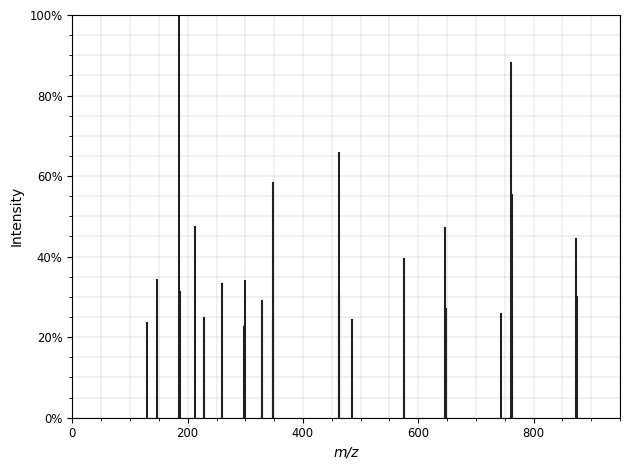

In [3]:
ms2_spectrum_5672 = get_MS2_object(full_calibrated_mzml_path, 5672)
plot_MS2(ms2_spectrum=ms2_spectrum_5672)

Grab the intensity and mz arrays from the object above:

In [4]:
# grab mz values from that ms2 object as a list
spectrum_mz = ms2_spectrum_5672.mz
# grab intensity from that ms2 object as a list
spectrum_int = ms2_spectrum_5672.intensity

Here are the numerical values AKA how we represent our list of peaks:
```python
spectrum_mz =
[129.10229301 147.11281745 185.16487986 186.16810345 213.15977385
 229.11842622 260.19708681 298.14008063 300.15565245 328.18728919
 347.22931143 348.23238243 462.25621643 463.25947053 484.20451703
 575.34033321 646.37762047 647.38017268 743.39337543 761.40367098
 762.4065894  763.40944677 874.48766569 875.49046204]


spectrum_int =
[2174.818  3145.84   9230.925  2883.7764 4380.564  2282.9873 3063.1228
 2072.459  3142.8696 2672.6929 5380.33   2240.3975 6059.931  2831.662
 2237.5989 3632.9626 4356.975  2494.9565 2366.8223 8133.1064 5098.785
 2226.6924 4098.929  2766.6738]
```

In [5]:
# Intensity and mz values are parallel arrays, which you can either count the lengths of 
# or just assert and see it doesn't throw an error
assert(len(spectrum_int) == len(spectrum_mz))

#### Choosing the right bin width

Before we start binning, we need to choose our bin size. Using bins of 1 Da (rounding to nearest integer):

* In the 129th idx: 2174.818
* In the 147th idx: 3145.84
* In the 185th idx: 9230.925
* ... and so on for an array of length ~880

---

#### Why do we want at most 1 peak per bin?

When each bin contains at most one peak, we preserve **maximum information**. If multiple peaks fall into the same bin, one intensity overwrites another — we lose data.

If we had 200 unique m/z values ranging from 100–300 and rounded to the nearest integer, we'd quickly run into overlaps. Every value between 129.0 ≤ m/z < 130.0 would collapse into index 129.

Finer-grained buckets reduce collisions:

| Precision | Array Length (max m/z = 880) |
|-----------|------------------------------|
| 1 Da | 880 buckets |
| 0.1 Da | 8,800 buckets |
| 0.01 Da | 88,000 buckets |


---

#### Accurate vs. Naive approach

Here's the Naive approach with making such a vector. Here, we round down each mz to the nearest integer.
$$
\text{Approach 1: Rounding to nearest integer (1 Da bins)} \\[0.5em]
\begin{align}
\text{Here's a list with 880 zeroes filled in: } &\quad [\underset{0}{0}, \underset{1}{0}, \underset{2}{0}, \ldots, \underset{879}{0}, \underset{880}{0}] \\[0.5em]
\text{Now, let's add a sample of such values at each index:} & \quad [\underset{0}{0}, \ldots, \underset{129}{2174.818}, \ldots, \underset{147}{3145.84}, \ldots, \underset{880}{0}] 
\end{align}
$$

Like we mentioned though, this takes a lot of accuracy away, and results in quite a few collisions. The approach using finer (to the nearest 0.01 mz) buckets:

$$
\text{Approach 2: Rounding to nearest 0.01 Da (higher precision)} \\[0.5em]
\begin{align}

\text{Here's a list with 88,000 zeroes filled in: } &\quad [\underset{0}{0}, \underset{1}{0}, \underset{2}{0}, \ldots, \underset{87999}{0}, \underset{88000}{0}] \\[0.5em]
\text{Now, let's add a sample of such values at each index:} & \quad [\underset{0}{0}, \ldots, \underset{12910}{2174.818}, \ldots, \underset{14711}{3145.84}, \ldots, \underset{88000}{0}] 
\end{align}
$$

=== Per-Spectrum Collision Analysis ===
File: 04-17-23_CA_Tryp_HCD_10min_CLEAN-calib.mzML
Total spectra analyzed: 8835

--- Bin Size = 1.0 Da ---
  Spectra with collisions: 6288 / 8835
  Mean collisions per spectrum: 6.44
  Max collisions in a spectrum: 79
  Mean collision rate: 11.57%

--- Bin Size = 0.01 Da ---
  Spectra with collisions: 9 / 8835
  Mean collisions per spectrum: 0.00
  Max collisions in a spectrum: 2
  Mean collision rate: 0.01%


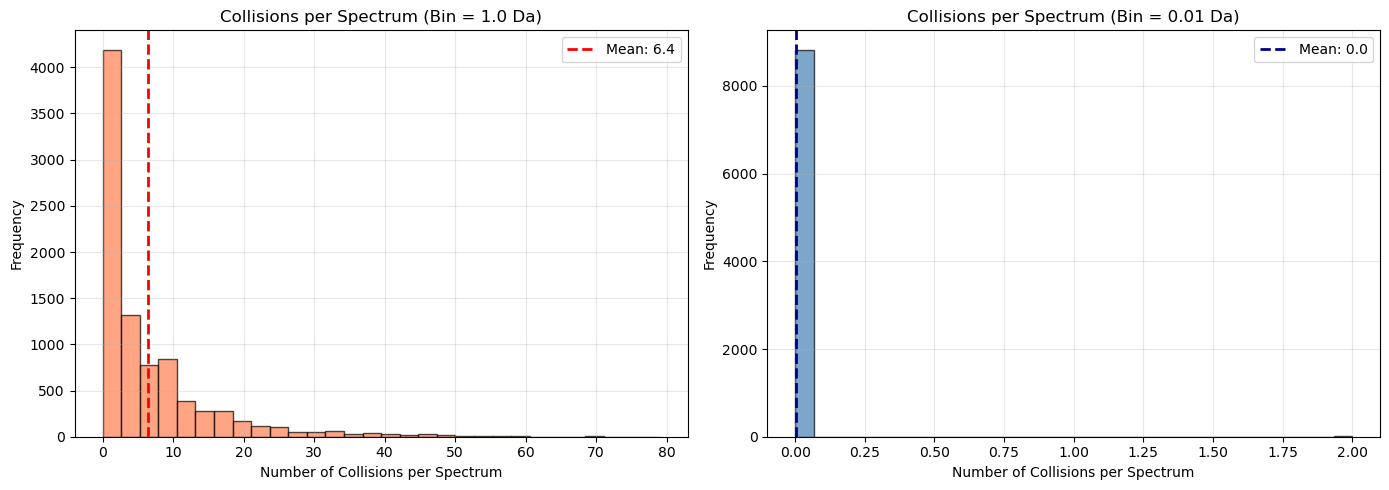

In [6]:
# @title Run this to see the difference in collisions between widths
plot_and_show_statistics_for_collisions("Biogen_ALS_Pilot_1A9_020120-calib-averaged.mzML")

#### Why "collision rate between spectrum pairs"?

Above, we compare the collision rate when binning with 1 Da vs 0.01 Da. Here's why this matters:

**Example:** Consider two spectra, A and B, each with only one peak:
- Spectrum A has a peak at **90.41** m/z
- Spectrum B has a peak at **90.42** m/z

| Bin Width | Spectrum A | Spectrum B | Result |
|-----------|------------|------------|--------|
| **1.0 Da** | bin 90 | bin 90 | **Collision!** Both spectra appear identical |
| **0.01 Da** | bin 9041 | bin 9042 | **No collision.** Spectra are correctly distinguished |

With coarse bins, spectra that are actually different can appear similar. This is clearly a false positive. Fine bins preserve the distinction between spectra, which is essential for accurate clustering.

This demonstrates why we need a smaller bin size. However, we can't just make bins arbitrarily small, we must choose a size that is both fine enough to preserve information and realistic for mass spectrometer accuracy.

The key consideration is that mass spectrometers have physical precision limitations. While a spectrometer might output a value like $ m/z =  10.023130 $, it cannot actually distinguish measurements to that level of precision. In practice, mass spectrometers are reliably accurate to approximately two decimal places (0.01 Da).

In [7]:
WIDTH_OF_BIN = 0.01
LENGTH = int(max(spectrum_mz) // WIDTH_OF_BIN +1) # integer rounding up one.
print(f"We have to fit our m/zs into bins by rounding them to the nearest {WIDTH_OF_BIN}")
print(f"The length of our (simulated) array will be {LENGTH}")


We have to fit our m/zs into bins by rounding them to the nearest 0.01
The length of our (simulated) array will be 87550



---

### Step 1: Spectrum Binning

Now we implement the first step of the pipeline:

**Goal:** Convert the spectrum to a sparse vector using small mass bins (0.01 Da) to tightly capture fragment masses.

We've already chosen our bin width (0.01 Da). Now we'll define a function to convert m/z values to their binned index.

For example: 129.103 m/z → index 12910

In [8]:
# @title Conversion to sparse vector

def to_idx(mz):
    """
    Convert m/z value to a sparse vector index.
    """
    # concretely: 129.103 // 0.01 == 12910
    return int(mz // WIDTH_OF_BIN) # rounds down to nearest 0.01.

#### Sparse vectors: An optimization

With 88,000 possible bins but only ~24 peaks per spectrum, most bins are empty. Storing 88,000 zeros is wasteful.

A **dictionary** stores only the non-zero entries:

Instead of:
```
[0, 0, 0, ..., 2174.818, 0, 0, ..., 3145.84, 0, 0, ..., 0]  # 88,000 elements!
```

We store:
```
{12910: 2174.818, 14711: 3145.84, ...}  # Only 24 entries
```

In [10]:
# @title Create the sparse representation: map from m/z indices to intensities

mz_intensity_map = {}
# Populate the sparse vector with our spectrum data
for i, mz in enumerate(spectrum_mz):
    # Convert each m/z to its corresponding index
    mz_index = to_idx(mz)
    # Store the intensity
    mz_intensity_map[mz_index] = spectrum_int[i]

What does this look like?

In [11]:
# @title Run to visualize the dictionary 
print("The map dictionary looks like:\n")
print(f"{'m/z bin':<12} {'Intensity':<12} {'Original m/z'}")
print("-" * 40)
for i, (idx, intensity) in enumerate(sorted(mz_intensity_map.items())):
    print(f"{idx:<12} {intensity:<12.3f} ({spectrum_mz[i]:.4f})")

print("\n" + "-" * 40)
print(f"Total entries: {len(mz_intensity_map)} (instead of ~88,000 zeros!)")

The map dictionary looks like:

m/z bin      Intensity    Original m/z
----------------------------------------
12910        2174.818     (129.1023)
14711        3145.840     (147.1128)
18516        9230.925     (185.1649)
18616        2883.776     (186.1681)
21315        4380.564     (213.1598)
22911        2282.987     (229.1184)
26019        3063.123     (260.1971)
29814        2072.459     (298.1401)
30015        3142.870     (300.1557)
32818        2672.693     (328.1873)
34722        5380.330     (347.2293)
34823        2240.397     (348.2324)
46225        6059.931     (462.2562)
46325        2831.662     (463.2595)
48420        2237.599     (484.2045)
57534        3632.963     (575.3403)
64637        4356.975     (646.3776)
64738        2494.957     (647.3802)
74339        2366.822     (743.3934)
76140        8133.106     (761.4037)
76240        5098.785     (762.4066)
76340        2226.692     (763.4094)
87448        4098.929     (874.4877)
87549        2766.674     (875.4905)


**Step 1 complete!** We have a sparse representation of our spectrum.

---

### Step 2: Feature Hashing

Now for the second step of the pipeline:

**Goal:** Compress the sparse vector (with indices up to 88,000) into a fixed-size vector of 800 dimensions.

#### Why do we need this?

Our sparse dictionary is memory-efficient, but we still have problems:
- **Clustering algorithms need fixed-size vectors.** You can't easily compute distances between dictionaries with different keys.
- **The potential dimensionality is still huge.** Even with only 24 entries, those indices span 0–88,000.

#### What's a hash function?

A **hash function** converts input data of any size into a fixed-size output:

1. **Deterministic**: Same input → same output every time
2. **Fixed output size**: Always the same length, regardless of input
3. **Fast**: Efficiently computable

#### How hashing works for our spectra

A hash function maps any sparse index to a fixed range of buckets:

$$\text{hash}(12910) \rightarrow 347 \quad \text{(bucket between 0 and 799)}$$

$$\text{hash}(14711) \rightarrow 102 \quad \text{(another bucket)}$$

**Core Idea:** Similar spectra will have similar hash vectors because they share many of the same m/z bins, which hash to the same buckets.

#### Why 800 buckets?

We balance two concerns:
- **Large enough** to minimize collisions (different peaks hashing to the same bucket)
- **Small enough** to be computationally efficient for clustering

800 is a good middle ground for typical MS2 spectra.

In [12]:
HASH_BUCKETS = 800

#### The hash function

We'll use `rapidhash`, a fast hash function, combined with the modulo operator to map any sparse index to a bucket in the range `[0, 799]`.

In [13]:
def hasher(num: int) -> int:
    """
    Hash function that maps sparse indices to a fixed number of buckets.
    
    Input: Large sparse index (e.g., 12910)
    Output: Small bucket index (0 to 799)
    """
    # Convert integer to bytes for hashing (rapidhash expects byte input)
    byte_representation = int(num).to_bytes(8, 'little')
    
    # Hash and mod to get bucket index in range [0, hash_buckets-1]
    return rapidhash(byte_representation) % HASH_BUCKETS

In [14]:
# @Title Example: see how large indices get mapped to small buckets
print(f"Sparse index 12910 → bucket {hasher(12910)}")
print(f"Sparse index 14711 → bucket {hasher(14711)}")
print(f"Sparse index 87550 → bucket {hasher(87550)}")

Sparse index 12910 → bucket 629
Sparse index 14711 → bucket 319
Sparse index 87550 → bucket 354


#### Handling collisions

What happens when two different m/z bins hash to the same bucket? This is called a **collision**. 

We handle collisions by **adding the intensities together**. As we will see in a minute, this is acceptable because it, on average, happens rarely enough that it "preserves similarity".

In [15]:
# Initialize our final hash vector with all zeros
hash_vector = [0] * HASH_BUCKETS 

# Populate the hash buckets with intensities from our sparse map
for sparse_idx, intensity in mz_intensity_map.items():
    # Map the sparse index to a bucket
    bucket_idx = hasher(sparse_idx)
    
    # Add intensity to that bucket (handles collisions by summation)
    hash_vector[bucket_idx] += intensity

#### The final hash vector

Notice how the sparse map lets us iterate over only the non-zero entries — we never touch the ~88,000 zeros!

In [16]:
# Display the hash vector
non_zero_buckets = [(i, val) for i, val in enumerate(hash_vector) if val > 0]

print(f"Hash vector has {len(non_zero_buckets)} non-zero buckets out of {HASH_BUCKETS} total\n")

nonzero_hash_df = pd.DataFrame(non_zero_buckets, columns=['Bucket', 'Intensity'])
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
display(nonzero_hash_df)

Hash vector has 24 non-zero buckets out of 800 total



,Bucket,Intensity
0,40,3142.87
1,78,2072.46
2,115,5098.79
3,236,2240.40
4,241,4356.98
5,246,2672.69
6,251,2494.96
7,255,4098.93
8,270,3063.12
9,319,3145.84


**Step 2 complete!** We now have a fixed-size hash vector.

---

## 2.6 Summary: The Complete Pipeline

We've completed the full spectral hashing pipeline:

| Step | Representation | Size |
|------|----------------|------|
| **Original** | (m/z, intensity) pairs | 24 peaks |
| **Step 1: Binning** | Sparse dictionary | 24 entries (of 88,000 possible) |
| **Step 2: Hashing** | Fixed-size vector | 800 dimensions |

---

### Putting It All Together: The OMS Workflow

Now we can see how spectral hashing enables efficient OMS. Define an embedding function:

```python
def embed_spectrum(mz_array, intensity_array) -> list[float]:
    # Step 1: Bin → Step 2: Hash
    return hash_vector  # length 800
```

---

**Phase 1: Build the Library (one-time preprocessing)**

1. For all spectra with **known identity** (from a spectral library), imagine we have such a function:
```python
hash_vector_library = embed_spectrum(library_spectrum.mz: list[int], library_spectrum.intensity:list[int])
```

2. Cluster all library hash vectors using cosine similarity.

> **Lego analogy:** Sort all your known Lego pieces into piles before you start building.

---

**Phase 2: Identify Unknown Spectra (query phase)**

3. For each unknown **query spectrum**:
```python
hash_vector_query = embed_spectrum(query_spectrum.mz, query_spectrum.intensity)
```

4. Find the nearest cluster representative using cosine similarity.

5. If similarity exceeds a threshold → assign the query the peptide identity of that cluster.

> **Lego analogy:** When you need a piece, check which pile it belongs to. All pieces in that pile share ~ the same identity.

---

**Why does this work for modified peptides?**

A modified peptide shares MOST of its fragment ions with the unmodified version. The modification only shifts a subset of peaks. Because of this shared structure, the hash vectors remain similar enough that modified and unmodified versions cluster together — enabling identification regardless of PTMs.

> **Note:** We can only compare vectors of the same length. That's why Step 2 (hashing to a fixed 800 dimensions) is essential.


---

## 2.7 Similarity Preservation: Does Hashing Actually Work?

We've claimed that hashing "preserves similarity" — that similar spectra remain similar after compression. Let's prove it.

**What does "preserve similarity" mean?**

If two spectra are similar in the original 88,000-dimensional space, they should also be similar in the compressed 800-dimensional space. The relative ordering of "similar" vs. "dissimilar" pairs should remain roughly the same.

---

#### Measuring similarity with cosine similarity

We use the **dot product** to measure how similar two vectors are:

$$\vec{x} \cdot \vec{z} > \vec{x} \cdot \vec{y} \implies \vec{x} \text{ is more similar to } \vec{z} \text{ than to } \vec{y}$$

**Cosine similarity** is just a normalized dot product (scaled between -1 and 1, like...cosine!).

**Example:**

$\vec{x} = [0, 500, 0, 1200] \quad \text{(Spectrum A)}$

$\vec{z} = [0, 480, 0, 1190] \quad \text{(Spectrum B — similar)}$

$\vec{y} = [100, 30, 2000, 0] \quad \text{(Spectrum C — different)}$

**Dot products:**

$\vec{x} \cdot \vec{z} = (0)(0) + (500)(480) + (0)(0) + (1200)(1190) = 1,668,000$

$\vec{x} \cdot \vec{y} = (0)(100) + (500)(30) + (0)(2000) + (1200)(0) = 15,000$

Since $1,668,000 \gg 15,000$, spectra A and B would be **clustered together**.

<details>
<summary>Click to see the full cosine similarity formula</summary>

$$\cos(\theta) = \frac{\vec{x} \cdot \vec{z}}{|\vec{x}| |\vec{z}|}$$

where $\theta$ is the angle between vectors. When $\theta = 0°$ (identical direction), $\cos(\theta) = 1$. When $\theta = 90°$ (perpendicular), $\cos(\theta) = 0$.
</details>

Click play to go through a visual example (no sound), starting from the top.

<video controls>
  <source src="SimilarityPreservationComplete.mp4" type="video/mp4">
</video>


> **Note:** Some similarity loss is expected due to hash collisions, but this loss is typically small and acceptable for clustering purposes.

#### Empirical validation

The code below compares pairwise similarities between spectra in both the original (sparse) and hashed representations. If hashing works, the correlation should be high.

In simpler terms, did you notice that when we went from binned -> binned + hashed spectra, the peaks didn't keep their original spots? We'll show that a hash function actually does this so reliably, that we still KEEP the similarity or dissimilarity property of the original binned spectra. 
- Again, we are **not** comparing binned spectra to binned + hashed, we're following the video exactly, and ensuring that if 2 binned spectra are similar, then their respective hashed versions will also be similar.
    - Like aforementioned, you also cannot actually compare two lists of 80,000 (binned) and 800 (binned + hashed) elements. This is another reason why we compare things in their respective "spaces."


Similarity Preservation Analysis:
Cosine similarity between sparse and hash similarities: 0.892
This shows how well the hash representation preserves the similarity structure
A similarity close to 1 indicates good similarity preservation
shape of correlation matrix: (2, 2) shape of other arrays: (414, 414) (414, 414)


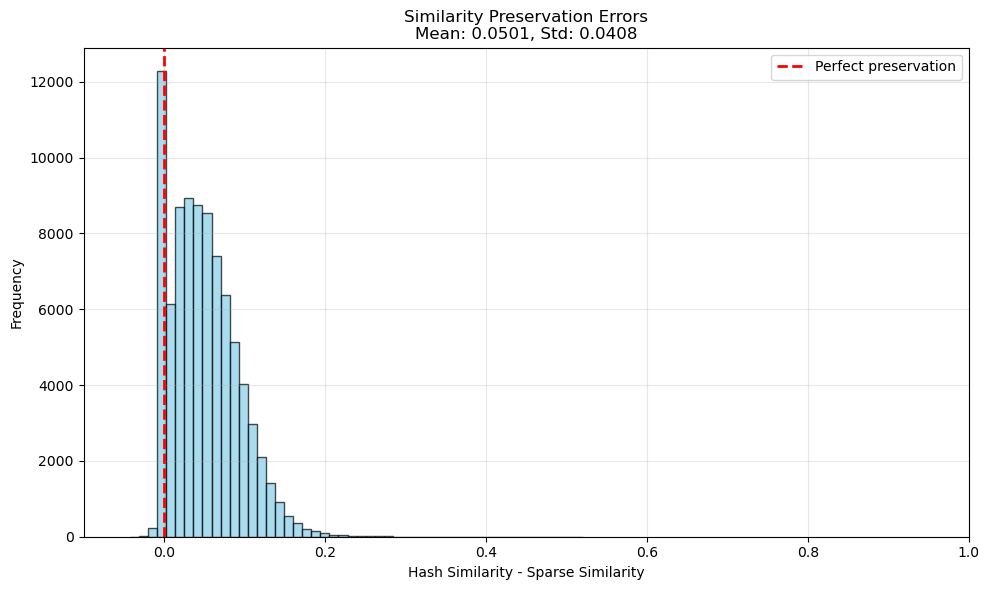


Detailed Statistics:
Number of pairwise comparisons: 85,491
Sparse similarities range: 0.000 to 0.933
Hash similarities range: 0.000 to 0.936
Mean absolute difference: 0.0504
Pearson correlation coefficient: 0.8716
Clustering based on unhashed similarities, showing both matrices with same ordering:


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



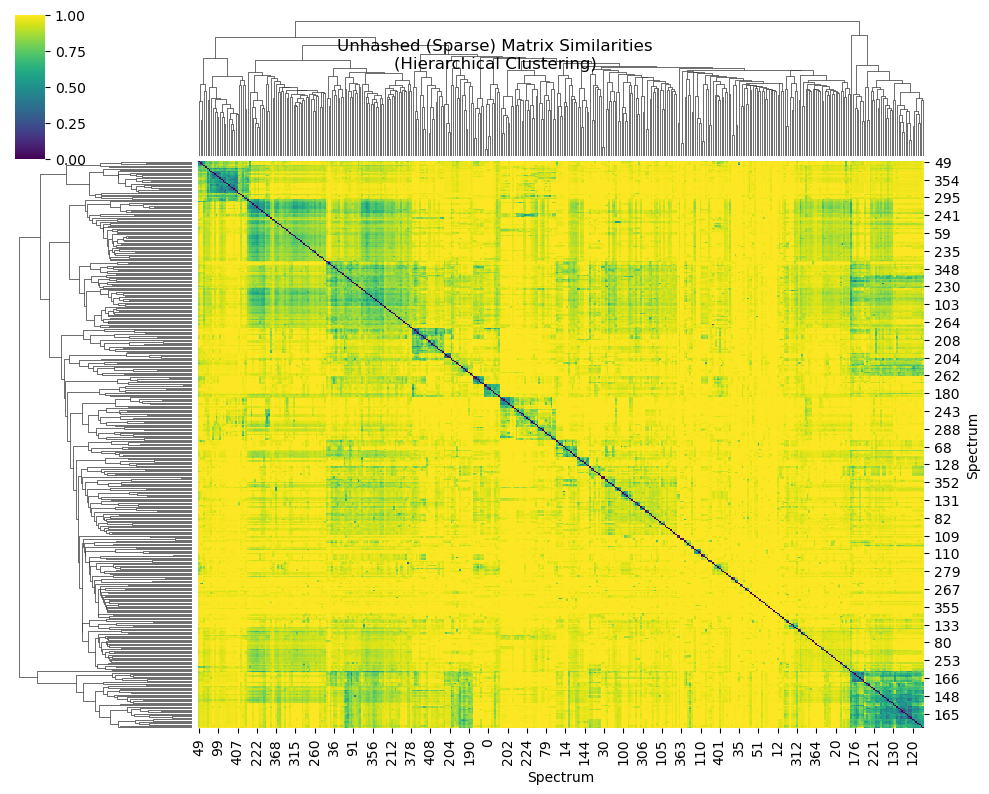

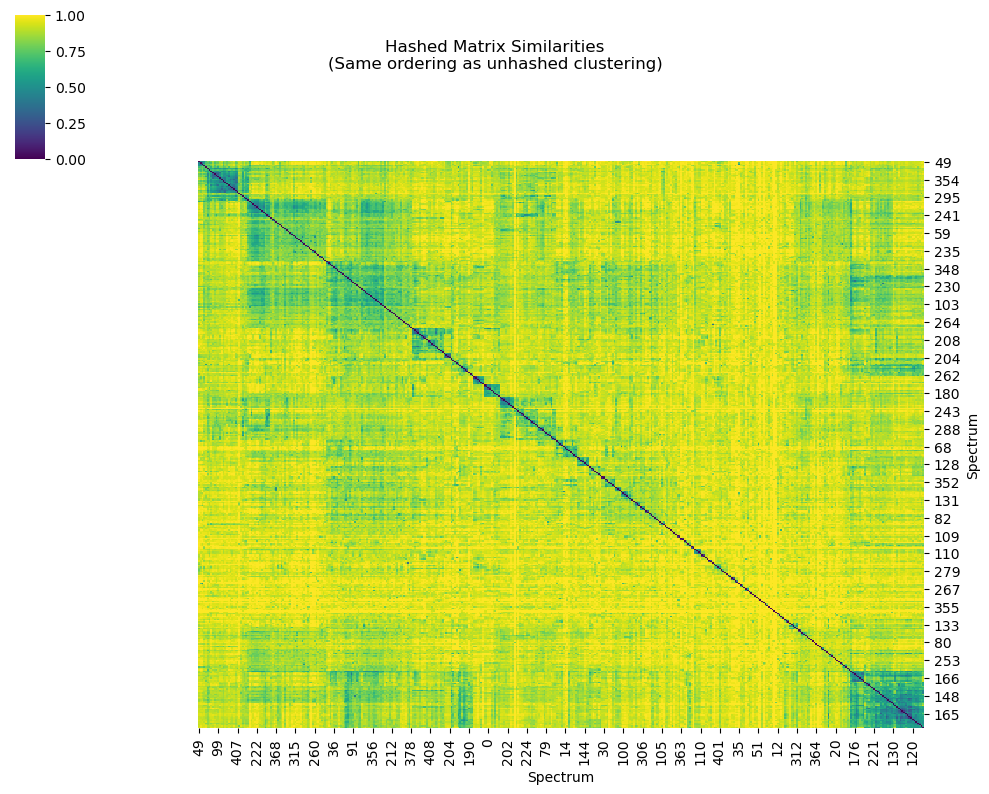

In [17]:
prove_similarity_preservation_plots_and_statistics("04-17-23_CA_Tryp_HCD_10min_CLEAN.mzML") 
# This is a very computationally expensive task, we use a snippet of the original file for the sake of time

---

## Worked Example: Spectral Hashing End-to-End

Now let's see the complete pipeline on real data. We'll work with the peptide **AVVQDPALKPLALVYGEATSR**.

Below is its theoretical ion ladder:

In [18]:
make_ion_ladder('AVVQDPALKPLALVYGEATSR')

,b#,b_ion_m/z,b_ion_sequence,y_ion_sequence,y_ion_m/z,y#
0,1,72.04,A,VVQDPALKPLALVYGEATSR,"2,127.18",20
1,2,171.11,AV,VQDPALKPLALVYGEATSR,"2,028.11",19
2,3,270.18,AVV,QDPALKPLALVYGEATSR,"1,929.04",18
3,4,398.24,AVVQ,DPALKPLALVYGEATSR,"1,800.98",17
4,5,513.27,AVVQD,PALKPLALVYGEATSR,"1,685.96",16
5,6,610.32,AVVQDP,ALKPLALVYGEATSR,"1,588.91",15
6,7,681.36,AVVQDPA,LKPLALVYGEATSR,"1,517.87",14
7,8,794.44,AVVQDPAL,KPLALVYGEATSR,"1,404.78",13
8,9,922.54,AVVQDPALK,PLALVYGEATSR,"1,276.69",12
9,10,"1,019.59",AVVQDPALKP,LALVYGEATSR,"1,179.64",11


Let's look at how this ion ladder can be plotted as a spectrum. The purpose of this is to visualize the spread of m/z values. The intensity values here are meaningless.

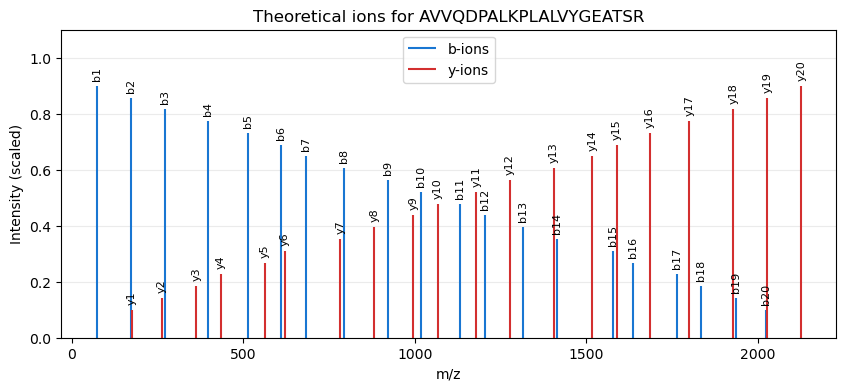

In [19]:
b_mz = [
    72.044114, 171.112528, 270.180942, 398.239520, 513.266463,
    610.319227, 681.356341, 794.440405, 922.535368, 1019.588132,
    1132.672196, 1203.709310, 1316.793374, 1415.861788, 1578.925108,
    1635.946572, 1764.989165, 1836.026279, 1937.073958, 2024.105986
]

y_mz = [
    2127.179698, 2028.111284, 1929.042870, 1800.984292, 1685.957349,
    1588.904585, 1517.867471, 1404.783407, 1276.688444, 1179.635680,
    1066.551616, 995.514502, 882.430438, 783.362024, 620.298704,
    563.277240, 434.234647, 363.197533, 262.149854, 175.117826
]

plot_theoretical_ions(b_mz, y_mz, 'AVVQDPALKPLALVYGEATSR')

Now let's plot a real spectrum and use the theoretical ions above to to annotate it. We'll start with scan 9970, the spectrum of the unmodified AVVQDPALKPLALVYGEATSR peptide.

Failed to convert matplotlib figure to Plotly; falling back to matplotlib display


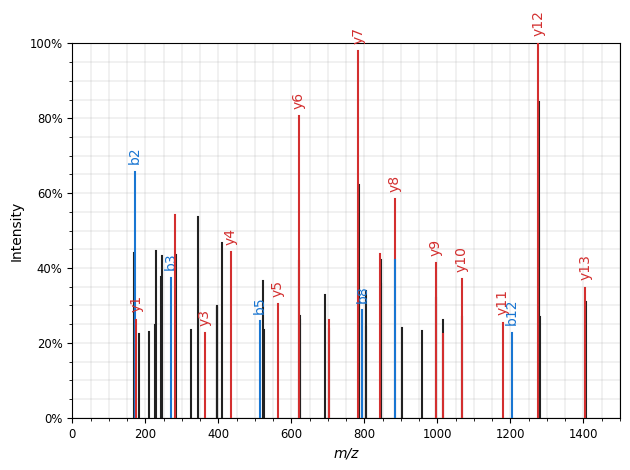

In [21]:
plot_MS2(get_MS2_object(full_calibrated_mzml_path, 9970, peptide = 'AVVQDPALKPLALVYGEATSR'))

Although there is inevitable noise (un-annotated peaks) that deviates from the theoretical ions, this spectrum overall aligns really well with the unmodified AVVQDPALKPLALVYGEATSR peptide. In other words, **a significant proportion of this spectrum's total intensity is accounted for by its peptide's theoretical ions.** Let's look at a modified version of the peptide.

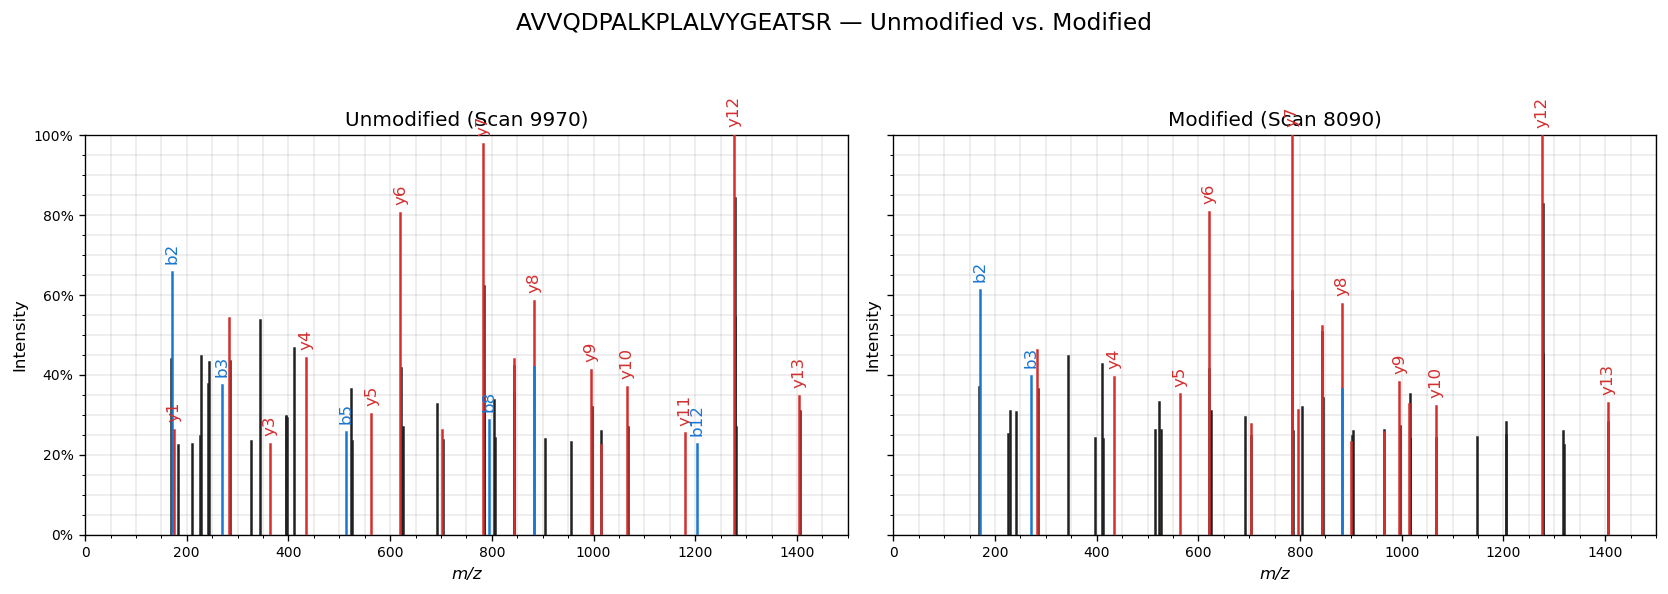

In [ ]:

seq = 'AVVQDPALKPLALVYGEATSR'
spec_left  = get_MS2_object(full_calibrated_mzml_path, 9970, peptide=seq) #AVVQDPALKPLALVYGEATSR
spec_right = get_MS2_object(full_calibrated_mzml_path, 8090, peptide=seq) #AVVQ[Common Artifact:Deamidation on Q]DPALKPLALVYGEATSR

# Make two panels with shared axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120, sharex=True, sharey=True)
axes[0].set_xlabel("m/z")
axes[0].set_ylabel("Intensity")

# Left panel = scan 9970 (unmodified peptide)
sup.spectrum(spec_left, ax=axes[0], grid=True)
axes[0].set_title("Unmodified (Scan 9970)")

# Right panel = scan 8090 (modified peptide)
sup.spectrum(spec_right, ax=axes[1], grid=True)
axes[1].set_title("Modified (Scan 8090)")

fig.suptitle("AVVQDPALKPLALVYGEATSR — Unmodified vs. Modified", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space at top
plt.show()

We can repeat that process using an unmodified and modified spectrum from 2 other peptides in our mzml file: IITHPNFNGNTLDNDIMLIK and RMVNNGHSFNVEYDDSQDK.

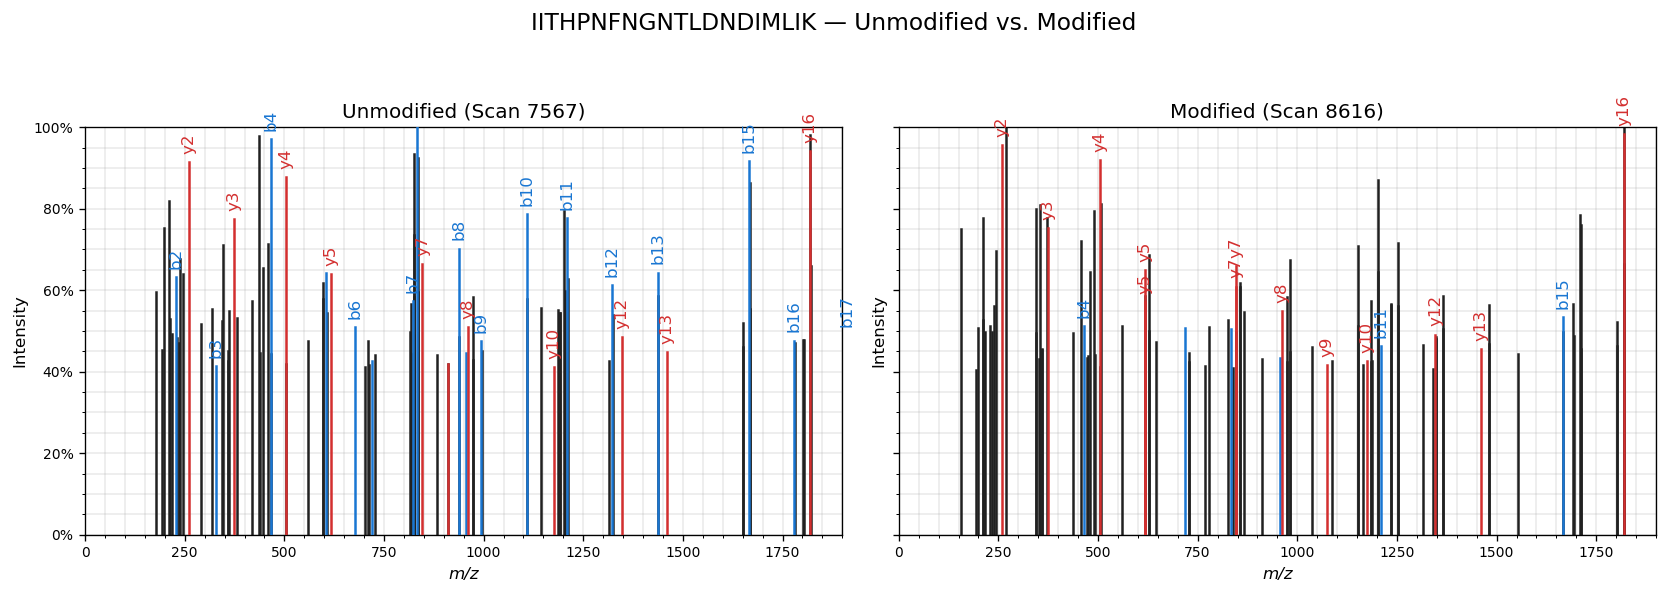

In [ ]:

seq = 'IITHPNFNGNTLDNDIMLIK'
spec_left  = get_MS2_object(full_calibrated_mzml_path, 7567, peptide=seq) #IITHPNFNGNTLDNDIMLIK
spec_right = get_MS2_object(full_calibrated_mzml_path, 8616, peptide=seq) #[Common Artifact:Carbamyl on X]IITHPNFNGNTLDNDIMLIK

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120, sharex=True, sharey=True)
axes[0].set_xlabel("m/z")
axes[0].set_ylabel("Intensity")

# Left panel = scan 7567 (unmodified)
sup.spectrum(spec_left, ax=axes[0], grid=True)
axes[0].set_title("Unmodified (Scan 7567)")

# Right panel = scan 8616 (modified)
sup.spectrum(spec_right, ax=axes[1], grid=True)
axes[1].set_title("Modified (Scan 8616)")

fig.suptitle("IITHPNFNGNTLDNDIMLIK — Unmodified vs. Modified", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

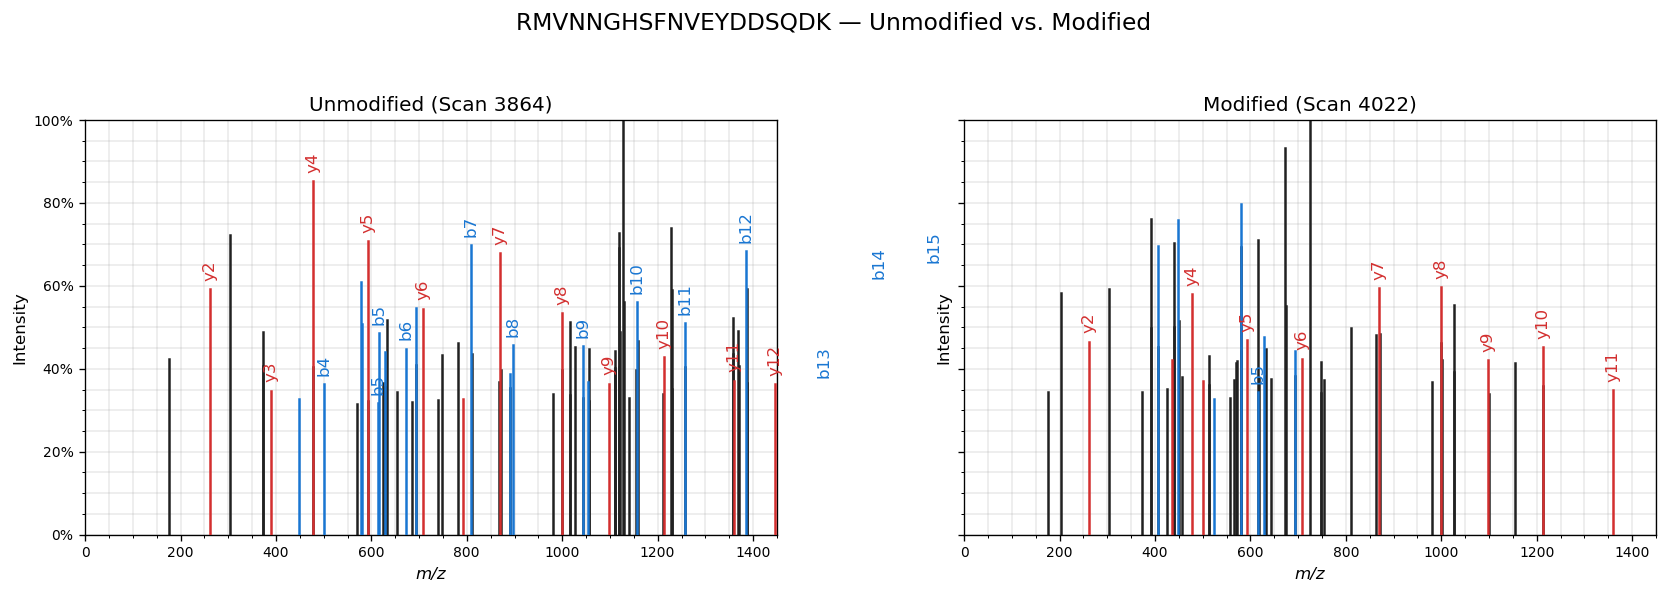

In [25]:

seq = 'RMVNNGHSFNVEYDDSQDK'
spec_left  = get_MS2_object(full_calibrated_mzml_path, 3864, peptide=seq) #RMVNNGHSFNVEYDDSQDK
spec_right = get_MS2_object(full_calibrated_mzml_path, 4022, peptide=seq) #RMVNN[Common Artifact:Deamidation on N]GHSFNVEYDDSQDK

# Make two panels with shared zxes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120, sharex=True, sharey=True)
axes[0].set_xlabel("m/z")
axes[0].set_ylabel("Intensity")

# Left panel = scan 3864 (unmodified)
sup.spectrum(spec_left, ax=axes[0], grid=True)
axes[0].set_title("Unmodified (Scan 3864)")

# Right panel = scan 4022 (modified)
sup.spectrum(spec_right, ax=axes[1], grid=True)
axes[1].set_title("Modified (Scan 4022)")

fig.suptitle("RMVNNGHSFNVEYDDSQDK — Unmodified vs. Modified", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

There are two trends you might be noticing across these spectra:

1. Generally, when a modified or unmodified peptide's spectrum is annotated with the theoretical ions for it's associated unmodified peptide, there is a significant proportion of that spectrum's intensity accounted for by the theoretical ions.
2. Unmodified spectra better "match"/are better accounted for by the unmodified peptide's theoretical ions than modified spectra. But there is not an extrememly noticeable difference.
<br></br>
What if we were to use the theoretical ions of one peptide to annotate the spectrum of another? Let's try using the theoretical ions from AVVQDPALKPLALVYGEATSR to annotate the spectrum of the RMVNNGHSFNVEYDDSQDK peptide. We'll plot that on the right side. On the left, we'll plot the spectrum of a modified AVVQDPALKPLALVYGEATSR spectrum and annotate it with the AVVQDPALKPLALVYGEATSR ions (just like earlier).


In short, we are plotting spectra from **2 different base peptides** and annotating them using the theoretical ions from **only 1 peptide.**

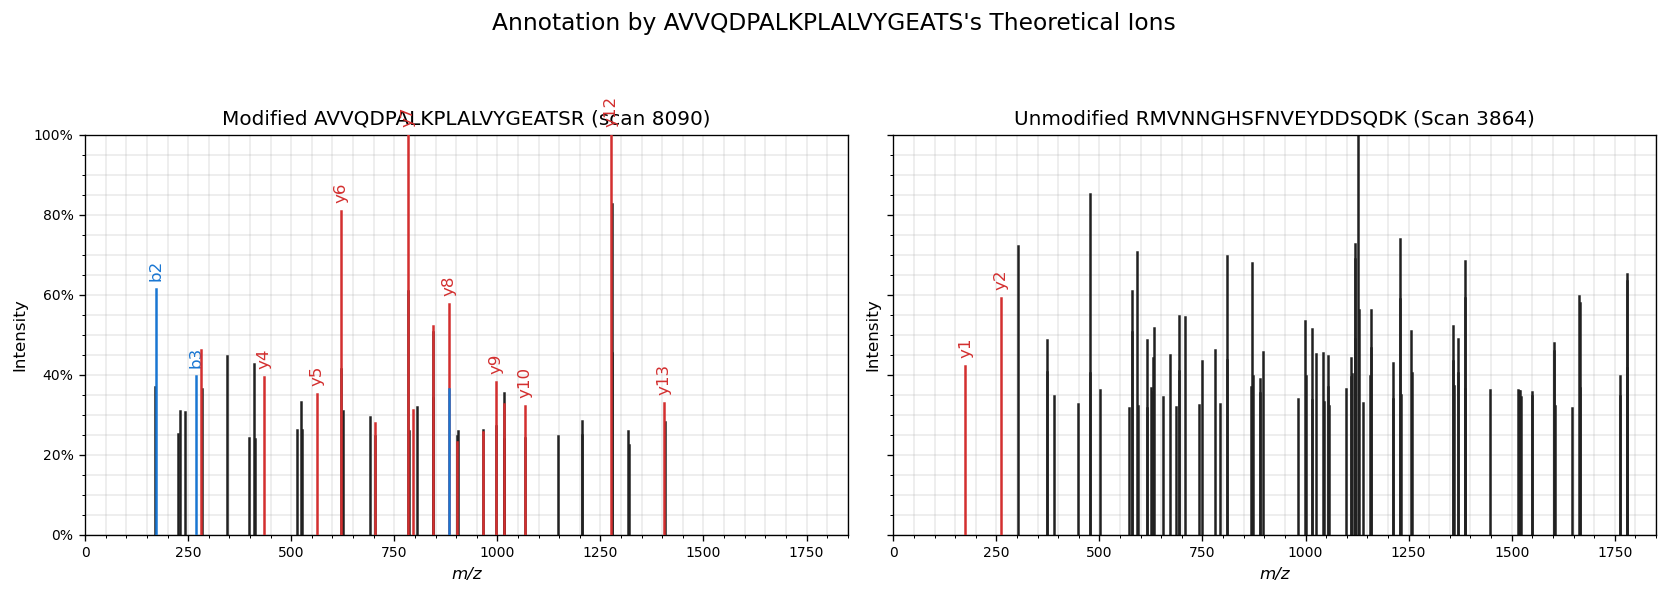

In [28]:
seq = 'AVVQDPALKPLALVYGEATSR'
spec_left  = get_MS2_object(full_calibrated_mzml_path, 8090, peptide=seq)
spec_right = get_MS2_object(full_calibrated_mzml_path, 3864, peptide=seq)

# Make two panels with shared axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120, sharex=True, sharey=True)
axes[0].set_xlabel("m/z")
axes[0].set_ylabel("Intensity")

# Left panel = modified AVVQDPALKPLALVYGEATSR = scan 8090
sup.spectrum(spec_left, ax=axes[0], grid=True)
axes[0].set_title("Modified AVVQDPALKPLALVYGEATSR (scan 8090)")

# Right panel = unmodified RMVNNGHSFNVEYDDSQDK = scan 3864
sup.spectrum(spec_right, ax=axes[1], grid=True)
axes[1].set_title("Unmodified RMVNNGHSFNVEYDDSQDK (Scan 3864)")

fig.suptitle("Annotation by AVVQDPALKPLALVYGEATS's Theoretical Ions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space at the top for the suptitle
plt.show()

Now we'll annotate the spectrum of the modified RMVNNGHSFNVEYDDSQDK peptide using the theoretical ions of RMVNNGHSFNVEYDDSQDK (on the left) and AVVQDPALKPLALVYGEATSR (on the right).We are plotting **1 spectrum** and annotating it using **2 different theoretical ions from 2 different base peptides.**

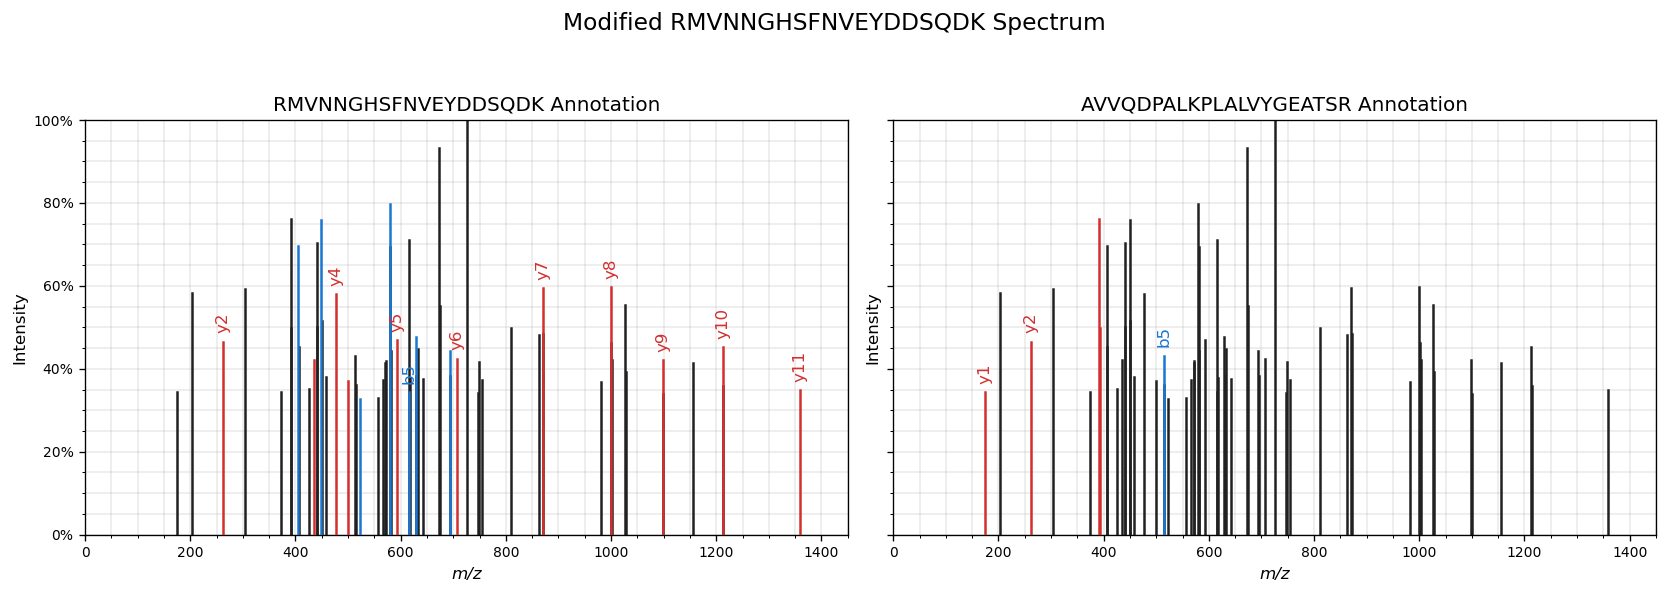

In [29]:
seq_1= 'RMVNNGHSFNVEYDDSQDK'
seq_2 = 'AVVQDPALKPLALVYGEATSR'

spec_left  = get_MS2_object(full_calibrated_mzml_path, 4022, peptide=seq_1)
spec_right = get_MS2_object(full_calibrated_mzml_path, 4022, peptide=seq_2)

# Make two panels with shared axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120, sharex=True, sharey=True)
axes[0].set_xlabel("m/z")
axes[0].set_ylabel("Intensity")

# Left panel = RMVNNGHSFNVEYDDSQDK Annotation, Scan 4022
sup.spectrum(spec_left, ax=axes[0], grid=True)
axes[0].set_title("RMVNNGHSFNVEYDDSQDK Annotation")

# Right panel = AVVQDPALKPLALVYGEATSR Annotation, scan 4022
sup.spectrum(spec_right, ax=axes[1], grid=True)
axes[1].set_title("AVVQDPALKPLALVYGEATSR Annotation")

fig.suptitle("Modified RMVNNGHSFNVEYDDSQDK Spectrum", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

You're hopefully noticing a much more dramatic trend now. In the first example, where we annotated two different spectra (from different base peptides) using the same theoretical ions (from only one base peptide), a much greater proportion of the "matching" spectrum's intensity was accounted for by the theoretical ions than of the other spectrum's intensity. In the second example, where we annotated the same spectrum using two different sets of theoretical ions (one belonging to the "matching" peptide, and one not), a much greater proportion of the spectrum (annotated by it's matching peptide)'s intensity was accounted for by the ions than of the spectrum (annoted by the other peptide)'s intensity.
<br></br>
Now, we can actually begin binning our spectrum!

In [ ]:

import importlib
import SpectrumWithTransformations as swt_module
import SpectrumWithTransformations

importlib.reload(swt_module)

# This function should read in an mzml file and return an object of type SpectrumWithTransformations
# Based off of get_MS2_object from Sam Payne lesson 4
def get_SWT_object(
    mzml_path: str,
    scan_number: int,
    full_sequence = None,
) -> "SpectrumWithTransformations":
    
    index = scan_number -1 #scan_number is 1-based, index is 0-based
    with mzml.MzML(mzml_path, use_index=True) as reader: #use_index=True allows us to avoid reading through the entire mzml file
        selected_spectrum = reader.get_by_index(index)
    # Test to see if we accessed the correct scan: PASSED!
    # precursor_mz = selected_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
    # print(precursor_mz)
    

    # This finds the cooresponding values in the .mzml file to create our MS2 for a given scan (see the params)
    spectrum_id = selected_spectrum['id']
    retention_time = selected_spectrum['scanList']['scan'][0]['scan start time']
    precursor_mz = selected_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
    precursor_charge = int(selected_spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state'])
    mz_array = np.asarray(selected_spectrum['m/z array'])
    intensity_array = np.asarray(selected_spectrum['intensity array'])
    
    swt_object = SpectrumWithTransformations.SpectrumWithTransformations(
        identifier=spectrum_id,
        scan_number=scan_number,
        precursor_mz=precursor_mz,
        precursor_charge=precursor_charge,
        mz_array=mz_array,
        intensity_array=intensity_array,
        retention_time=retention_time,
        annotation_dictionary=None,
        binned_mz=None,
        hashed_mz=None,
    )

    if full_sequence:
        swt_object = swt_object.annotate_proforma(
            proforma_str = full_sequence,
            fragment_tol_mass = 0.01, # We consider two peaks (actual and theoretical) "equivalent" if they are within +/- 0.01 Da
            fragment_tol_mode = 'Da',
            ion_types = 'by',
            max_ion_charge = max(1, precursor_charge - 1)
        )
    return swt_object

In [31]:
scan_8090 = get_SWT_object(
    mzml_path=full_calibrated_mzml_path,
    scan_number = 8090,
    full_sequence = 'AVVQ[Deamidated]DPALKPLALVYGEATSR',
)

plot_MS2(scan_8090, title='Scan 8090: Original Spectrum')

NameError: name 'get_SWT_object' is not defined

In [ ]:
WIDTH_OF_BIN = 0.01
def to_idx(num):
    return int(num // WIDTH_OF_BIN)

# Bin the mz
scan_8090.binned_mz = np.empty_like(scan_8090.mz, dtype=int)
for i in range(len(scan_8090.mz)):
    scan_8090.binned_mz[i] = to_idx(scan_8090.mz[i])

# Create a binned_spectrum SWT object for plotting purposes only
binned_spectrum = get_SWT_object(
    mzml_path=full_calibrated_mzml_path,
    scan_number = 8090,
    full_sequence = 'AVVQ[Deamidated]DPALKPLALVYGEATSR',
)
for i in range (len(binned_spectrum.mz)):
    binned_spectrum.mz[i] = scan_8090.binned_mz[i] #Re-writing the mz_array with the binned mz values

# Plot the binned spectrum
plot_MS2(binned_spectrum, 'Scan 8090: Binned Spectrum')


In [30]:
HASH_BUCKETS = 800  # Target dimensionality

def hasher(num: int) -> int:
    """
    Hash function that maps sparse indices to a fixed number of buckets.

    Input: Large sparse index (e.g., 12910)
    Output: Small bucket index (0 to 399)
    """
    # Convert integer to bytes for hashing (rapidhash expects byte input)
    byte_representation = int(num).to_bytes(8, 'little')
    # Hash and mod to get bucket index in range [0, hash_buckets-1]
    return rapidhash(byte_representation) % HASH_BUCKETS

# Set-up
hashed_mz = []
hashed_intensity = []
hash_vector = [0] * HASH_BUCKETS
mz_intensity_map = {}
for i, mz in enumerate(scan_8090.mz):
    mz_intensity_map[to_idx(mz)] = scan_8090.intensity[i]

# Hash the mz and add the intensities as we go
for sparse_idx, intensity in mz_intensity_map.items():
    bucket_idx = hasher(sparse_idx)
    hash_vector[bucket_idx] += intensity
    hashed_mz.append(bucket_idx)
    hashed_intensity.append(hash_vector[bucket_idx])

# Update the hashed mz and intensities
scan_8090.hashed_mz = hashed_mz
scan_8090.hashed_intensity = hashed_intensity

# Create a hashed_spectrum SWT object for plotting purposes only
hashed_spectrum = get_SWT_object(
    mzml_path=full_calibrated_mzml_path,
    scan_number = 8090,
    full_sequence = 'AVVQ[Deamidated]DPALKPLALVYGEATSR',
)
for i in range (len(hashed_spectrum.mz)):
    hashed_spectrum.mz[i] = scan_8090.hashed_mz[i] #Re-writing the mz_array with the hashed mz values
    hashed_spectrum.intensity[i] = scan_8090.hashed_intensity[i] #Re-writing the intensity_array with the summed intensity values

# Plot the hashed spectrum
plot_MS2(hashed_spectrum, 'Scan 8090: Hashed Spectrum')

NameError: name 'scan_8090' is not defined

### Side by side
<img src="Scan8090_Original.png" width="370">
<img src="Scan8090_Binned.png" width="370">
<img src="Scan8090_Hashed.png" width="370">